# Assignment Week 8
Data Augmentation and AE Networks usinng MNIST

In [1]:
#MNIST is a build in Pytorch dataset
from torchvision import datasets as dts
from torchvision.transforms import ToTensor 
train = dts.MNIST(
    root = 'data',
    train = True,                         
    transform = ToTensor(), 
    download = True,            
)
test = dts.MNIST(
    root = 'data', 
    train = False, 
    transform = ToTensor()
)

100%|██████████| 9912422/9912422 [00:00<00:00, 81227786.06it/s]


Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 32624749.21it/s]


Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 26392401.94it/s]


Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 279542.31it/s]

Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw



## Exercise 1
Augment the training data with 6 differnet suitable augmentations
* use the PyTorch augmentation framework -> https://pytorch.org/vision/stable/transforms.html 
* visualize some examples

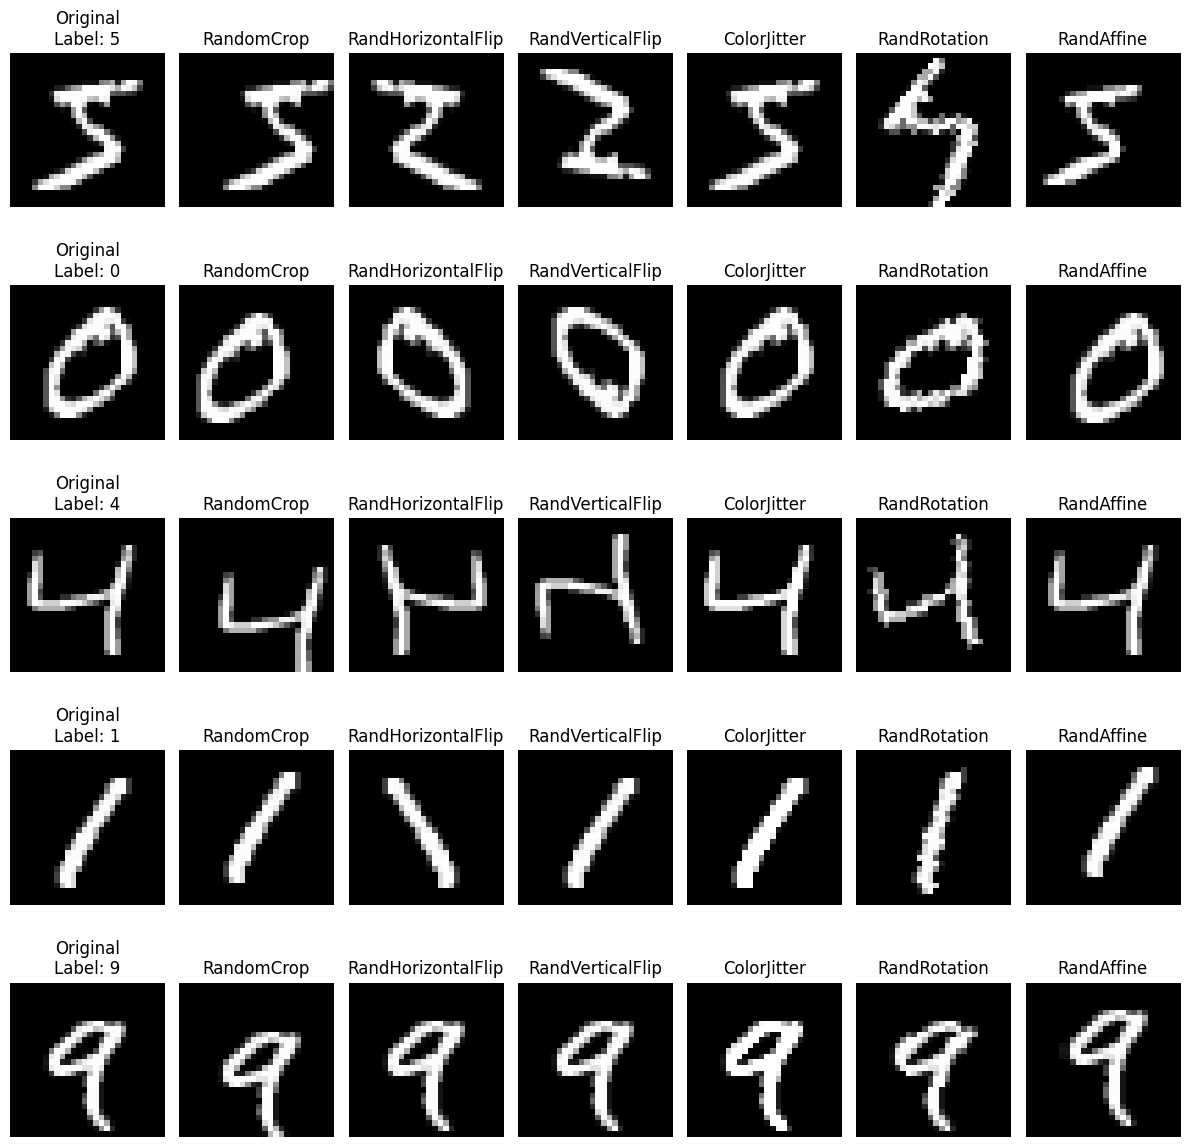

In [2]:
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
augmentations = [
    transforms.RandomCrop(size=28, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.4, hue=0.3),
    transforms.RandomRotation(degrees=45),
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1), scale=(0.9, 1.1), shear=0.1),
]

augmented_images = []
for i, (image, label) in enumerate(train):
    if i == 2000:
      break
    augmented_images.extend([(aug(image), label) for aug in augmentations])

num_examples = 5
fig, axes = plt.subplots(num_examples, len(augmentations) + 1, figsize=(12, 12))

titles=["RandomCrop","RandHorizontalFlip","RandVerticalFlip","ColorJitter","RandRotation","RandAffine"]

for i in range(num_examples):
    original_image, original_label = train[i]
    axes[i, 0].imshow(original_image.squeeze(), cmap='gray')
    axes[i, 0].set_title(f'Original\nLabel: {original_label}')

    for j, (augmented_image, _) in enumerate(augmented_images[i * len(augmentations):(i + 1) * len(augmentations)]):
        axes[i, j + 1].imshow(augmented_image.squeeze(), cmap='gray')
        axes[i, j + 1].set_title(f'{titles[j]}')

    for ax in axes[i]:
        ax.axis('off')

plt.tight_layout()
plt.show()

## Exercise 2
Build and train a MLP Autoencoder with 
* 2 Encoder Layers
* 2 Decoder Layers
* Identity Loss

In [3]:
import torch 
class AE(torch.nn.Module): #all nets inherit from nn.Module
    def __init__(self): #define layer types
        super(AE, self).__init__()

        self.encoder_hidden_layer = torch.nn.Linear(in_features= 784, out_features= 128,bias=False) 
        self.encoder_output_layer = torch.nn.Linear(128,64,bias=False)
        self.encode = torch.nn.Linear(64,64,bias=False)
        self.decoder_hidden_layer = torch.nn.Linear(64,128,bias=False)
        self.decoder_output_layer = torch.nn.Linear(128,784,bias=False)
        
    def forward(self, x): #build network
        x = x.flatten()
        output = self.encoder_hidden_layer(x)
        output = torch.relu(output) 
        output = self.encoder_output_layer(output) #w*X
        output = torch.relu(output)
        output = self.encode(output)
        code = torch.relu(output)
        output = self.decoder_hidden_layer(code)
        output = torch.relu(output)
        output = self.decoder_output_layer(output)
        output = torch.relu(output)
        return {'output':output, 'latent': code}

In [4]:
#get instance of perceptron model
model = AE()
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)


In [5]:
if torch.cuda.is_available():
  model = model.to("cuda")
model.train() #set to train mode
epoch = 10
running_loss = 0.0
for epoch in range(epoch):
    for i,(images,_) in enumerate(train):
      optimizer.zero_grad()
      if torch.cuda.is_available():
        images = images.to("cuda")
      y_pred = model(images)['output']
      loss = criterion(y_pred,images.flatten())
      # Backward pass
      loss.backward()      
      #make gradient update
      optimizer.step()
      running_loss += loss.item()
      
    print('Epoch: ', epoch, ' loss: ', running_loss/2000)
    running_loss = 0.0
    

Epoch:  0  loss:  1.0027483251561644
Epoch:  1  loss:  0.856025257852627
Epoch:  2  loss:  0.8266132229395443
Epoch:  3  loss:  0.8177263961560093
Epoch:  4  loss:  0.8079115088849794
Epoch:  5  loss:  0.7853563089887612
Epoch:  6  loss:  0.7752830733628362
Epoch:  7  loss:  0.7727209932720288
Epoch:  8  loss:  0.7685249073962914
Epoch:  9  loss:  0.7666454350419808


## Exercise 3


In [6]:
class AddGaussianNoise(object):
    def __init__(self, mean=0., std=0.25):
        self.std = std
        self.mean = mean
        
    def __call__(self, tensor):
        return tensor + torch.randn(tensor.size()) * self.std + self.mean
    
    def __repr__(self):
        return self.__class__.__name__ + '(mean={0}, std={1})'.format(self.mean, self.std)

Use the Gaussian Noise as augmentation and your AE to remove the noise.
* visualize input and output examples

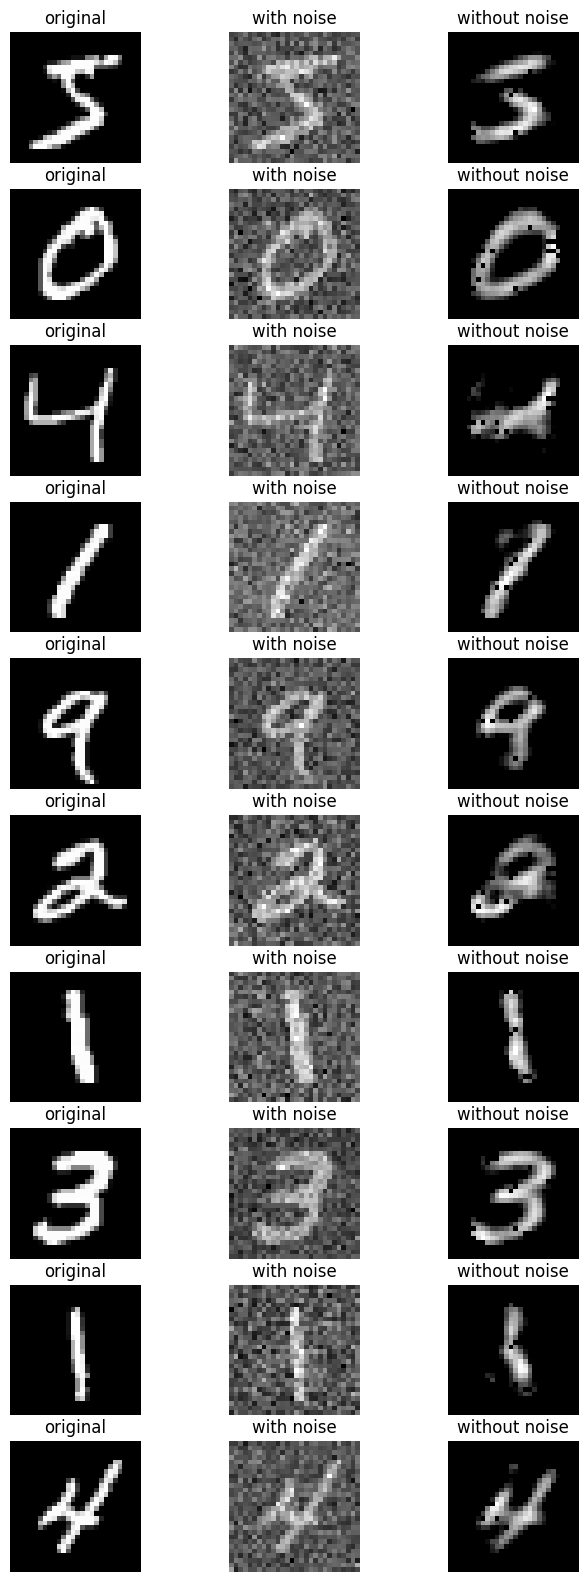

In [7]:

addGaussianNoise = AddGaussianNoise()

number_examples = 10
fig, ax = plt.subplots(number_examples, 3, figsize=(8, 4 * num_examples))
for i in range(number_examples):
  noised = addGaussianNoise(train[i][0][0])
  model=model.to("cuda")
  noised=noised.to("cuda")
  res=model(noised)
  ax[i,0].imshow(train[i][0][0], cmap='gray')
  ax[i,1].imshow(noised.cpu().detach().numpy(), cmap='gray')
  ax[i,2].imshow(model(noised)['output'].cpu().detach().numpy().reshape(28,28), cmap='gray')
  ax[i,0].set_title("original")
  ax[i,1].set_title("with noise")
  ax[i,2].set_title("without noise")
  ax[i,0].axis('off')
  ax[i,1].axis('off')
  ax[i,2].axis('off')


## Exercise 4
Clustering: extract the latent space representations of the train data and apply K-Means (from Scikit-Learn) with k=10. Use the data lables to evaluate the cluter quality.

In [13]:
from sklearn.cluster import KMeans
from sklearn.metrics import rand_score

In [9]:
latent = []
labels = []

for i in range(len(train)):
  labels.append(train[i][1])
  latent.append(model(train[i][0].to("cuda"))['latent'].cpu().detach().numpy())

In [16]:
#latents = torch.stack(latent)
#labels = torch.tensor(labels)

kmeans = KMeans(n_clusters=10, random_state=0)
clusters = kmeans.fit_predict(latent)



/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
